In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
class LSTM_SecStructure(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTM_SecStructure, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x) # h_n y c_n tienen forma (num_layers, batch, hidden_dim)
        out = self.fc(lstm_out) # (batch, seq_len, output_dim)
        return out, lstm_out, h_n, c_n # Devolvemos también el último hidden state y cell state

In [3]:
input_dim = 21 # one-hot encoding de aminoácidos (20 AA + X)
hidden_dim = 4
output_dim = 3 # Categorias a predecir: H, E, C (E2 de 3 cat, sino serian 8)
num_layers = 1
# Crear modelo
model = LSTM_SecStructure(input_dim, hidden_dim, output_dim, num_layers)

Ejercicio 80. Usando un código que permita transformar una secuencia proteica un tensor, y
utilizando el codigo provisto, instancie la LSTM y procese la secuencia. Analice: i) como
evoluciona la dimensión del h_n, c_n y out en función de los parámetros. ¿cómo se relaciona
la misma con ellos?

In [3]:
data = pd.read_csv('E2_train.csv')
data.head()

,seq,sst3,sst8
0,AETVESCLAKSHTENSFTNVXKDDKTLDRYANYEGCLWNATGVVVC...,CCCHHHHHCCCCEEEEEECCEECCCCCCEEEEECCEEEEEEEEEEE...,CCCHHHHHTSCCEEEEEESCEECTTTCCEEEEETTEEEEEEEEEEE...
1,ASQEISKSIYTCNDNQVXEVIYVNTEAGNAYAIISQVNEXIPXRLX...,CCCCEEEEEEEECCCEEEEEEEEECCCCCEEEEEEECCEEEEEEEE...,CCCCEEEEEEEETTTEEEEEEEEECTTSCEEEEEEETTEEEEEEEE...
2,XGSSHHHHHHSSGRENLYFQGXNISEINGFEVTGFVVRTTNADEXN...,CCCCCCCCCCCCCCCCCEEEEEEEEEECCEEEEEEEEEECHHHHHC...,CCCCCCCCCCCCCCCCCEEEEEEEEEECCEEEEEEEEEECHHHHHS...
3,SNADYNRLSVPGNVIGKGGNAVVYEDAEDATKVLKMFTTSQSNEEV...,CCCCCCCCCCEEEEEEECCCEEEEEECCCCCEEEEEECCCCCHHHH...,CCCCCCCCCCEEEEEEECSSEEEEEETTCTTEEEEEESSCCCHHHH...
4,DTVGRPLPHLAAAMQASGEAVYCDDIPRYENELFLRLVTSTRAHAK...,CCCCCCCCCCCHHHHHCCCCCCHHHCCCCCCCEEEEEEECCCCCEE...,CCTTSCCCCTTHHHHHTTCSCCGGGSCCCTTCEEEEEEECSSSSEE...


In [4]:
def one_hot_encoding(secuencias, aminoacidos="ACDEFGHIKLMNPQRSTVWY-"):

    aa_to_index = {aa: idx for idx, aa in enumerate(aminoacidos)}
    ohe_matrices = []
    
    for secuencia in secuencias:
        ohe_matrix = np.zeros((len(secuencia), len(aminoacidos)), dtype=np.float32)
        for i, aa in enumerate(secuencia):
            if aa in aa_to_index:
                ohe_matrix[i, aa_to_index[aa]] = 1.0
        ohe_matrices.append(ohe_matrix)
    
    return ohe_matrices

def one_hot_to_AA(seq_one_hot, aminoacidos="ACDEFGHIKLMNPQRSTVWY-"):
    aa_to_index = {idx: aa for idx, aa in enumerate(aminoacidos)}
    secuencia = ""
    for i in range(len(seq_one_hot)):
        index = np.argmax(seq_one_hot[:, i])
        secuencia += aa_to_index[index]
    return secuencia

In [22]:
input = one_hot_encoding(data['seq'])
print(input[0].shape)
print(len(data['seq'][0]))

(217, 21)
217


In [7]:
una_seq = torch.tensor(np.array([input[0]]))
out, lstm_out, h_n, c_n = model(una_seq)
print(f"Salida: {out.shape}")
print(f"Lstm out (primeros 10 AA): {lstm_out[:, 0:10, :]}")
print(f"Hidden state:{h_n.shape},\n {h_n}")
print(f"Cell state: {c_n.shape},\n {c_n}")


Salida: torch.Size([1, 217, 3])
Lstm out (primeros 10 AA): tensor([[[-0.0260, -0.0275, -0.0269, -0.1614],
         [-0.0226, -0.0575, -0.1503, -0.2851],
         [ 0.0295, -0.1359, -0.1248, -0.1210],
         [-0.0331, -0.1719, -0.1250, -0.1311],
         [-0.0343, -0.1091, -0.2020, -0.2752],
         [-0.0663, -0.1408, -0.1678, -0.3478],
         [-0.0136, -0.0462, -0.1204, -0.2945],
         [-0.0034, -0.0760, -0.0621, -0.1336],
         [-0.0335, -0.0431, -0.0310, -0.2373],
         [-0.0653, -0.1534, -0.0161, -0.1823]]], grad_fn=<SliceBackward0>)
Hidden state:torch.Size([1, 1, 4]),
 tensor([[[-0.0393, -0.0722, -0.0889, -0.2252]]], grad_fn=<StackBackward0>)
Cell state: torch.Size([1, 1, 4]),
 tensor([[[-0.1037, -0.2001, -0.2038, -0.3944]]], grad_fn=<StackBackward0>)


El hidden state y el cell state tienen dimension num_layers x n_seqs x hidden_dim

In [8]:
fake_seq = ['A' *10]
fake_seq = torch.tensor(one_hot_encoding(fake_seq))
print(f'input shape: {fake_seq.shape}')
out, lstm_out, h_n, c_n = model(fake_seq)
print(f"Salida: {out.shape}")
print(f"Lstm out: {lstm_out[:,0:10,:]}")
print(f"Hidden state:{h_n.shape},\n {h_n}")
print(f"Cell state: {c_n.shape},\n {c_n}")

input shape: torch.Size([1, 10, 21])
Salida: torch.Size([1, 10, 3])
Lstm out: tensor([[[-2.6005e-02, -2.7465e-02, -2.6936e-02, -1.6141e-01],
         [-3.8193e-02, -3.7445e-02, -2.3818e-02, -2.5574e-01],
         [-4.3125e-02, -4.1881e-02, -1.5064e-02, -3.0788e-01],
         [-4.4927e-02, -4.4236e-02, -7.8756e-03, -3.3688e-01],
         [-4.5517e-02, -4.5587e-02, -3.1351e-03, -3.5326e-01],
         [-4.5677e-02, -4.6373e-02, -2.4242e-04, -3.6264e-01],
         [-4.5701e-02, -4.6829e-02,  1.4695e-03, -3.6807e-01],
         [-4.5688e-02, -4.7093e-02,  2.4711e-03, -3.7123e-01],
         [-4.5670e-02, -4.7244e-02,  3.0553e-03, -3.7308e-01],
         [-4.5657e-02, -4.7331e-02,  3.3961e-03, -3.7417e-01]]],
       grad_fn=<SliceBackward0>)
Hidden state:torch.Size([1, 1, 4]),
 tensor([[[-0.0457, -0.0473,  0.0034, -0.3742]]], grad_fn=<StackBackward0>)
Cell state: torch.Size([1, 1, 4]),
 tensor([[[-0.1265, -0.1419,  0.0073, -0.7304]]], grad_fn=<StackBackward0>)


/tmp/ipykernel_277076/3547904209.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  fake_seq = torch.tensor(one_hot_encoding(fake_seq))


Al pasarle 10 AA iguales, el hidden state se estabiliza y deja de cambiar (ver lstm out, donde cada entrada en el eje seq_len es el hidden state en esa posición)

Ejercicio 81. Utilizando para entrenar el conjunto de secuencias de entrenamiento entrene la
LSTM y luego determine en un subconjunto de secuencias (puede usar algunas del set de
entrenamiento y/o usar el de validación) el % medio de aciertos para predecir E2 de 3 y 8
categorìas. a) Compare el % de acuerdos de un modelo sin entrenar y luego de haberlo
entrenado.

Nota: si bien las LSTM manejan secuencias de longitud variable, en un mismo batch todas
deben tener la misma longitud por lo que para entrenarlas (sin modificar las secuencias) debe
ingresarlas de a una (o hacer que los batches tengan dimensión 1).

In [5]:
def E2_to_num(sst, cat = 'HEC'):
    cat_to_num = {'H': 0, 'E': 1, 'C':2}
    num_seq = [cat_to_num[char] for char in sst]
    return torch.tensor(num_seq)

def pred_to_E2(output):  
    
    preds = torch.argmax(output, dim=2)  # (1, seq_len)
    preds = preds.squeeze(0)            # (seq_len,)
    
    idx_to_cat = {0: 'H', 1: 'E', 2: 'C'}
    pred_E2 = ''.join([idx_to_cat[int(i)] for i in preds])
    return pred_E2


In [6]:
train, test = train_test_split(data, test_size=0.2)


In [7]:
y_true = [E2_to_num(sst) for sst in train['sst3']]
y_true_E2 = [sst for sst in train['sst3']]
train_OHE = one_hot_encoding(train['seq']) 

In [12]:
input_dim = 21
hidden_dim = 8
output_dim = 3 
num_layers = 1

model = LSTM_SecStructure(input_dim, hidden_dim, output_dim, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 20

model.train()

for epoch in range(num_epochs):
    total_loss = 0.0

    for i in range(len(y_true)):

        x_seq = torch.tensor(train_OHE[i])        # Tensor con shape (seq_len_i, 21)
        y_seq = y_true[i]              # Tensor con shape (seq_len_i,) o similar

        x_seq = x_seq.unsqueeze(0)    
        y_seq = y_seq.unsqueeze(0)    

        optimizer.zero_grad()

        outputs, lstm_out, h_n, c_n = model(x_seq)  # outputs shape (1, seq_len_i, output_dim)

        # Para CrossEntropyLoss se espera input (N, C) y target (N)
        # Entonces necesitamos "aplanar" la secuencia para batch:
        outputs_reshaped = outputs.view(-1, outputs.size(-1))  # (seq_len_i, output_dim)
        y_seq_reshaped = y_seq.view(-1)                       # (seq_len_i,)

        loss = criterion(outputs_reshaped, y_seq_reshaped)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(y_true)}")


Epoch 1/20, Loss: 0.9435900749471785
Epoch 2/20, Loss: 0.9194731347464632
Epoch 3/20, Loss: 0.9131508346682442
Epoch 4/20, Loss: 0.908042397169765
Epoch 5/20, Loss: 0.903090339075657
Epoch 6/20, Loss: 0.899175107122236
Epoch 7/20, Loss: 0.8957190174234855
Epoch 8/20, Loss: 0.8922806522304267
Epoch 9/20, Loss: 0.8891505869317428
Epoch 10/20, Loss: 0.8862572043009362
Epoch 11/20, Loss: 0.883638728711592
Epoch 12/20, Loss: 0.8814082367652107
Epoch 13/20, Loss: 0.8795880208452517
Epoch 14/20, Loss: 0.8780774433773254
Epoch 15/20, Loss: 0.876817068488084
Epoch 16/20, Loss: 0.8756955093654526
Epoch 17/20, Loss: 0.874684797186706
Epoch 18/20, Loss: 0.8737611476937268
Epoch 19/20, Loss: 0.8729084960856585
Epoch 20/20, Loss: 0.8721150087932669


In [13]:
output, lstm_out, h_n, c_n = model(torch.tensor(np.array([train_OHE[1]]), dtype=torch.float32))

pred_E2 = pred_to_E2(output)

matches = sum(p == t for p, t in zip(pred_E2, train['sst3'].iloc[1]))
accuracy = matches / len(pred_E2)

print(f"Modelo entrenado 20 epocas: {accuracy}")


Modelo entrenado 20 epocas: 0.8431372549019608


In [14]:
model = LSTM_SecStructure(input_dim, hidden_dim, output_dim, num_layers)
output, lstm_out, h_n, c_n = model(torch.tensor(np.array([train_OHE[1]]), dtype=torch.float32))

pred_E2 = pred_to_E2(output)

matches = sum(p == t for p, t in zip(pred_E2, train['sst3'].iloc[1]))
accuracy = matches / len(pred_E2)

print(f"Modelo sin entrenar: {accuracy}")

Modelo sin entrenar: 0.17647058823529413


81c) Escriba un codigo que permitta agrupar las secuencias en “batches” e n (con n=30-100)
secuencias del mismo tamaño. Para ello sugerimos ordene las secuencias de mas corta a más
larga y tome las primeras n, y luego recorte aquellas más largas. Si bien es más facil recortar
de un sólo extremo, dado que las predicciones de E2 son peores en los bordes recomendamos
cortarlas de manera equitativa en ambos extremos.
Reentrene ahora el modelo utilizando los “batches” y analicé los resultados.

In [9]:
batch_size = 100

train['seq_len'] = train['seq'].str.len()
train = train.sort_values(by='seq_len', ascending=True)
train['batch'] = np.arange(len(train)) // batch_size


In [10]:
train = train[train['batch'] != (len(train) // batch_size)]

In [11]:
train['batch_min_len'] = train.groupby('batch')['seq_len'].transform('min')
train.head(5)


,seq,sst3,sst8,seq_len,batch,batch_min_len
5401,LAFQREGFGRQSMSEKRTKQ,CCCCCCCCCCCCCCCCCCCC,CCSCTTCTTCSCCCTTSCCC,20,0,20
8039,DETGVMDSLLEALQSGAAFR,CCCCHHHHHHHHHHHCCCCC,CCCCHHHHHHHHHHHSTTCC,20,0,20
1508,ACQAFYASSPRKSIHIGACA,CCEEECCCCHHHCEEEECCC,CCEEESTTSGGGCEEEECCC,20,0,20
4181,GEXXYQXMLXNLRXAEVKKNA,CHHHHHHHHHHHHHHHHHHCC,CHHHHHHHHHHHHHHHHHHTC,21,0,20
4296,RKKRKTEEESPLKDKAKKSKG,CCCCCCCCCCCCCCCCCCCCC,CCCCCCSSCCSCCCCSCCCCC,21,0,20


In [12]:
def trimm_seq_row(row, column = 'seq'):
    seq = row[column]
    actual_len = row['seq_len']
    target_len = row['batch_min_len']
    
    if actual_len > target_len:
        start = (actual_len - target_len) // 2
        end = start + target_len
        return seq[start:end]
    else:
        return seq


In [13]:
train['trimmed_seq'] = train.apply(trimm_seq_row, column = 'seq', axis=1)
train['trimmed_sst3'] = train.apply(trimm_seq_row, column = 'sst3', axis = 1)
train.head()

,seq,sst3,sst8,seq_len,batch,batch_min_len,trimmed_seq,trimmed_sst3
5401,LAFQREGFGRQSMSEKRTKQ,CCCCCCCCCCCCCCCCCCCC,CCSCTTCTTCSCCCTTSCCC,20,0,20,LAFQREGFGRQSMSEKRTKQ,CCCCCCCCCCCCCCCCCCCC
8039,DETGVMDSLLEALQSGAAFR,CCCCHHHHHHHHHHHCCCCC,CCCCHHHHHHHHHHHSTTCC,20,0,20,DETGVMDSLLEALQSGAAFR,CCCCHHHHHHHHHHHCCCCC
1508,ACQAFYASSPRKSIHIGACA,CCEEECCCCHHHCEEEECCC,CCEEESTTSGGGCEEEECCC,20,0,20,ACQAFYASSPRKSIHIGACA,CCEEECCCCHHHCEEEECCC
4181,GEXXYQXMLXNLRXAEVKKNA,CHHHHHHHHHHHHHHHHHHCC,CHHHHHHHHHHHHHHHHHHTC,21,0,20,GEXXYQXMLXNLRXAEVKKN,CHHHHHHHHHHHHHHHHHHC
4296,RKKRKTEEESPLKDKAKKSKG,CCCCCCCCCCCCCCCCCCCCC,CCCCCCSSCCSCCCCSCCCCC,21,0,20,RKKRKTEEESPLKDKAKKSK,CCCCCCCCCCCCCCCCCCCC


In [14]:
test['seq_len'] = test['seq'].str.len()
test= test.sort_values(by='seq_len', ascending=True)
test['batch'] = np.arange(len(test)) // batch_size
test = test[test['batch'] != (len(test) // batch_size)]
test['batch_min_len'] = test.groupby('batch')['seq_len'].transform('min')
test['trimmed_seq'] = test.apply(trimm_seq_row, axis = 1)
test['trimmed_sst3'] = test.apply(trimm_seq_row, column = 'sst3', axis = 1)
test.head()

,seq,sst3,sst8,seq_len,batch,batch_min_len,trimmed_seq,trimmed_sst3
6597,XSFNARRKLKGAILTTMLATAX,CCCCHHHHHHHHHHHHHHHCCC,CCCCHHHHHHHHHHHHHHHCCC,22,0,22,XSFNARRKLKGAILTTMLATAX,CCCCHHHHHHHHHHHHHHHCCC
5869,GPMEEQREILEQLKKTLQMLTVY,CHHHHHHHHHHHHHHHHHHCCCC,CHHHHHHHHHHHHHHHHHHCCCC,23,0,22,GPMEEQREILEQLKKTLQMLTV,CHHHHHHHHHHHHHHHHHHCCC
1064,ARTKQTARKSTGGXAPRKQLATKAA,CCCHHHHHHHHCCCCCHHHCCCCCC,CCCHHHHHHHHCCCCCGGGSCCCCC,25,0,22,RTKQTARKSTGGXAPRKQLATK,CCHHHHHHHHCCCCCHHHCCCC
2066,XQQVHVLSLDQIRAIRNTNEXTEGPT,CCCCCCCCCCCCCCCCCCCCCCCCCC,CCCCCCCCTTTCCCCCCCCCCCCCCC,26,0,22,QVHVLSLDQIRAIRNTNEXTEG,CCCCCCCCCCCCCCCCCCCCCC
3807,XAXAEAAEKAAKYAAEAAEKAAKAXAX,CCHHHHHHHHHHHHHHHHHHHHHHCCC,CCHHHHHHHHHHHHHHHHHHHHHHTCC,27,0,22,XAEAAEKAAKYAAEAAEKAAKA,HHHHHHHHHHHHHHHHHHHHHH


In [21]:
n_batches_train = train['batch'].max()
n_batches_test = test['batch'].max()
device = torch.device("cpu")

input_dim = 21
hidden_dim = 256
output_dim = 3 
num_layers = 2
n_batches_train = train['batch'].max()

model = LSTM_SecStructure(input_dim, hidden_dim, output_dim, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Pesos para clases desbalanceadas
all_labels = ''.join(train['trimmed_sst3'].tolist())
counts = Counter(all_labels)
total = sum(counts.values())
frequencies = [counts[c] / total for c in 'HEC']
weights = torch.tensor([1/f for f in frequencies], dtype=torch.float32)
#weights = weights / weights.sum()

criterion = nn.CrossEntropyLoss(weight=weights.to(device))

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total_preds = 0

    print(f"Epoch {epoch+1}/{num_epochs}")

    for batch_id, batch_df in train.groupby("batch"):
        batch_seqs = batch_df["trimmed_seq"].tolist()
        batch_x = torch.tensor(one_hot_encoding(batch_seqs), dtype=torch.float32).to(device)

        batch_y = [E2_to_num(sst) for sst in batch_df["trimmed_sst3"]]
        batch_y = torch.tensor(np.array(batch_y), dtype=torch.long).to(device)
        outputs, _, _, _ = model(batch_x)
        outputs = outputs.view(-1, output_dim)
        targets = batch_y.view(-1)

        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        epoch_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == targets).sum().item()
        total_preds += targets.numel()

    avg_loss = epoch_loss / n_batches_train
    accuracy = correct / total_preds

    print(f"  Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")

Epoch 1/50
  Loss: 1.0977 | Accuracy: 0.4046
Epoch 2/50
  Loss: 1.0018 | Accuracy: 0.5208
Epoch 3/50
  Loss: 0.9785 | Accuracy: 0.5286
Epoch 4/50
  Loss: 0.9733 | Accuracy: 0.5305
Epoch 5/50
  Loss: 0.9694 | Accuracy: 0.5321
Epoch 6/50
  Loss: 0.9650 | Accuracy: 0.5348
Epoch 7/50
  Loss: 0.9652 | Accuracy: 0.5346
Epoch 8/50
  Loss: 0.9598 | Accuracy: 0.5377
Epoch 9/50
  Loss: 0.9559 | Accuracy: 0.5398
Epoch 10/50
  Loss: 0.9496 | Accuracy: 0.5436
Epoch 11/50
  Loss: 0.9444 | Accuracy: 0.5482
Epoch 12/50
  Loss: 0.9387 | Accuracy: 0.5520
Epoch 13/50
  Loss: 0.9261 | Accuracy: 0.5585
Epoch 14/50
  Loss: 0.9222 | Accuracy: 0.5620
Epoch 15/50
  Loss: 0.9076 | Accuracy: 0.5690
Epoch 16/50
  Loss: 0.9040 | Accuracy: 0.5715
Epoch 17/50
  Loss: 0.8995 | Accuracy: 0.5739
Epoch 18/50
  Loss: 0.8950 | Accuracy: 0.5760
Epoch 19/50
  Loss: 0.8891 | Accuracy: 0.5792
Epoch 20/50
  Loss: 0.8884 | Accuracy: 0.5794
Epoch 21/50
  Loss: 0.8884 | Accuracy: 0.5787
Epoch 22/50
  Loss: 0.8816 | Accuracy: 0.58

In [24]:
index = 666

model.eval()
output, lstm_out, h_n, c_n = model(torch.tensor(np.array(one_hot_encoding(test['seq'].iloc[index])), dtype=torch.float32))

with torch.no_grad():
    pred_E2 = pred_to_E2(output)
print(pred_E2)
print(test['sst3'].iloc[index])

matches = sum(p == t for p, t in zip(pred_E2, test['sst3'].iloc[index]))
accuracy = matches / len(pred_E2)

print(f"Modelo entrenado: {accuracy}")

CCCCCCCCCCEECCCCCCECHCHCCCECHECECCCCECECCCHCCHCCCCCCCEEECCCCCCCCHCECECCCCCCCCECCHCCCECECECCCECHECCCCECECCCCCCCCECECCECCCCEEEHCCECEECCCCCCCCCEECHCCCCCCECCECCCCECCECECCCCHHCECCCCECECECCEC
CCCCCCCCCCCECCCCCECECCCCCCCCCEEEEECCCCCCCEEEEEEEECCEEEEEECCCCCCCCCEEEECCCCCCCECCCCCEEEEEECCCCCCCECCEEEECCCEECCCCEECEEEECCEHHHCCCCEEEEEECCCCCCEEEEEECCCCCCCCCCEEEEEEECCEEEEEECCECCCEEEEECC
Modelo entrenado: 0.6


# Bidireccionalidad

In [15]:
class LSTM_SecStructure(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bidirectional=True):

        super(LSTM_SecStructure, self).__init__()
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1 # Factor para el número de direcciones
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)
        # Ajustamos el tamaño de entrada de la capa fully connected

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        out = self.fc(lstm_out) # Aplicamos la capa lineal a todas las posiciones de la secuencia
        return out, lstm_out, h_n, c_n # Devolvemos también el último hidden state y cell state

In [18]:
n_batches_train = train['batch'].max()
n_batches_test = test['batch'].max()
device = torch.device("cpu")

input_dim = 21
hidden_dim = 16
output_dim = 3 
num_layers = 1
n_batches_train = train['batch'].max()

model = LSTM_SecStructure(input_dim, hidden_dim, output_dim, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Pesos para clases desbalanceadas
all_labels = ''.join(train['trimmed_sst3'].tolist())
counts = Counter(all_labels)
total = sum(counts.values())
frequencies = [counts[c] / total for c in 'HEC']
weights = torch.tensor([1/f for f in frequencies], dtype=torch.float32)
#weights = weights / weights.sum()

criterion = nn.CrossEntropyLoss(weight=weights.to(device))

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total_preds = 0

    print(f"Epoch {epoch+1}/{num_epochs}")

    for batch_id, batch_df in train.groupby("batch"):
        batch_seqs = batch_df["trimmed_seq"].tolist()
        batch_x = torch.tensor(np.array(one_hot_encoding(batch_seqs)), dtype=torch.float32).to(device)

        batch_y = [E2_to_num(sst) for sst in batch_df["trimmed_sst3"]]
        batch_y = torch.tensor(np.array(batch_y), dtype=torch.long).to(device)
        outputs, _, _, _ = model(batch_x)
        outputs = outputs.view(-1, output_dim)
        targets = batch_y.view(-1)

        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        epoch_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == targets).sum().item()
        total_preds += targets.numel()

    avg_loss = epoch_loss / n_batches_train
    accuracy = correct / total_preds

    print(f"  Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")

Epoch 1/50
  Loss: 1.1077 | Accuracy: 0.4419
Epoch 2/50
  Loss: 1.0548 | Accuracy: 0.5209
Epoch 3/50
  Loss: 0.9594 | Accuracy: 0.5516
Epoch 4/50
  Loss: 0.9187 | Accuracy: 0.5709
Epoch 5/50
  Loss: 0.8992 | Accuracy: 0.5812
Epoch 6/50
  Loss: 0.8887 | Accuracy: 0.5877
Epoch 7/50
  Loss: 0.8815 | Accuracy: 0.5925
Epoch 8/50
  Loss: 0.8756 | Accuracy: 0.5961
Epoch 9/50
  Loss: 0.8705 | Accuracy: 0.5995
Epoch 10/50
  Loss: 0.8658 | Accuracy: 0.6027
Epoch 11/50
  Loss: 0.8614 | Accuracy: 0.6056
Epoch 12/50
  Loss: 0.8572 | Accuracy: 0.6083
Epoch 13/50
  Loss: 0.8532 | Accuracy: 0.6109
Epoch 14/50
  Loss: 0.8493 | Accuracy: 0.6131
Epoch 15/50
  Loss: 0.8454 | Accuracy: 0.6153
Epoch 16/50
  Loss: 0.8413 | Accuracy: 0.6175
Epoch 17/50
  Loss: 0.8377 | Accuracy: 0.6194
Epoch 18/50
  Loss: 0.8347 | Accuracy: 0.6208
Epoch 19/50
  Loss: 0.8323 | Accuracy: 0.6223
Epoch 20/50
  Loss: 0.8302 | Accuracy: 0.6234
Epoch 21/50
  Loss: 0.8283 | Accuracy: 0.6243
Epoch 22/50
  Loss: 0.8265 | Accuracy: 0.62

82. b) El modelo bidireccional alcanza un mayor accuracy (65% vs 60% en el modelo unidireccional), a pesar de haber reducido el numero de capas de 2 a 1 y el tamaño de la capa oculta de 256 a 32.

In [27]:
una_seq = torch.tensor(np.array([input[0]]))
out, lstm_out, h_n, c_n = model(una_seq)
print(f"Salida: {out.shape}") # 1 * largo de seq * N categorias a predecir
print(f"Hidden state:{h_n.shape},\n {h_n}") # Tanto el cell state como el hidden state tiene dimension 16 (es uno de los hiperparametros elegidos)
print(f"Cell state: {c_n.shape},\n {c_n}")

Salida: torch.Size([1, 217, 3])
Hidden state:torch.Size([2, 1, 16]),
 tensor([[[-0.3368,  0.6233, -0.3156,  0.0541, -0.1555, -0.4780,  0.0609,
           0.4192,  0.1183, -0.0618, -0.0287,  0.2483,  0.0355, -0.0448,
          -0.6155,  0.1911]],

        [[-0.2929,  0.2219, -0.4334,  0.4495,  0.4733, -0.3186, -0.5220,
           0.0057, -0.2028, -0.2910, -0.2032, -0.1901,  0.0445, -0.0672,
           0.1263, -0.0636]]], grad_fn=<StackBackward0>)
Cell state: torch.Size([2, 1, 16]),
 tensor([[[-0.5305,  1.4810, -0.3401,  0.0678, -0.2194, -0.6601,  0.0907,
           0.8186,  0.1344, -0.0979, -0.0418,  0.4247,  0.0361, -0.0501,
          -0.9954,  0.4001]],

        [[-0.5338,  0.2794, -0.5536,  0.6924,  0.5827, -0.4358, -0.7129,
           0.0077, -0.2902, -0.3930, -0.2606, -0.2961,  0.1209, -0.0750,
           0.1629, -0.1282]]], grad_fn=<StackBackward0>)


Accuracy vs longitud de la secuencia

In [31]:
model.eval()
acc = []
seq_len = []

for index, _ in enumerate(test['seq']):
    output, lstm_out, h_n, c_n = model(torch.tensor(np.array(one_hot_encoding(test['seq'].iloc[index])), dtype=torch.float32))

    with torch.no_grad():
        pred_E2 = pred_to_E2(output)

    matches = sum(p == t for p, t in zip(pred_E2, test['sst3'].iloc[index]))
    accuracy = matches / len(pred_E2)
    acc.append(accuracy)
    seq_len.append(len(pred_E2))


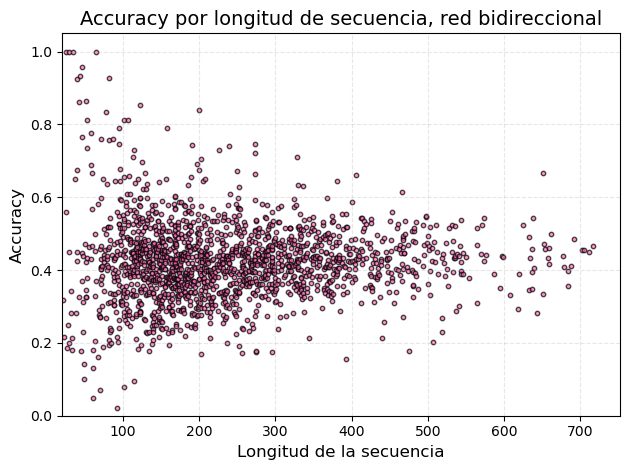

In [40]:
plt.scatter(seq_len, acc, c='hotpink', alpha=0.7, edgecolors='k', s=10)

plt.title('Accuracy por longitud de secuencia, red bidireccional', fontsize=14)
plt.xlabel('Longitud de la secuencia', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(0, 1.05)
plt.xlim(min(seq_len)*0.95, max(seq_len)*1.05)

plt.tight_layout()
plt.show()

Hay mayor dispersión en secuencias cortas.


**Menor cantidad de datos por secuencia**
En secuencias cortas (por ejemplo, de 10-20 residuos), cada error afecta mucho más el porcentaje de accuracy.

    Ejemplo: si una secuencia tiene 10 residuos y el modelo se equivoca en 2 → 80% accuracy.
    En una de 100 residuos, los mismos 2 errores → 98% accuracy.

**Menor contexto para el modelo**
Si las secuencias son muy cortas, el modelo tiene menos información para inferir estructura secundaria.

# Embeddings

Ejercicio 8.3 a) Utilizando en lugar del OHE un embedding obtenido de una matriz de
sustitución, entrene alguno de los modelos LSTM anteriores. Agregue los resultados a la tabla y
analicelos.

In [56]:
from Bio.Align import substitution_matrices

aas = substitution_matrices.load("BLOSUM62").alphabet
matrix = substitution_matrices.load("BLOSUM62")

blosum_dict = {aa: np.array(matrix[aa]) for aa in aas}


In [64]:
def blosum_as_embedding(seqs, blosum_dict):
    encoded_seqs = []
    
    for seq in seqs:
        matrix = np.zeros((len(seq), len(blosum_dict.keys())), dtype=np.float32)
        for i, aa in enumerate(seq):
            matrix[i,] = blosum_dict[aa]
        encoded_seqs.append(matrix)
    return encoded_seqs

In [67]:
n_batches_train = train['batch'].max()
n_batches_test = test['batch'].max()
device = torch.device("cpu")

input_dim = 24 # por el tamaño de la matriz de blosum
hidden_dim = 16
output_dim = 3 
num_layers = 1
n_batches_train = train['batch'].max()

model = LSTM_SecStructure(input_dim, hidden_dim, output_dim, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Pesos para clases desbalanceadas
all_labels = ''.join(train['trimmed_sst3'].tolist())
counts = Counter(all_labels)
total = sum(counts.values())
frequencies = [counts[c] / total for c in 'HEC']
weights = torch.tensor([1/f for f in frequencies], dtype=torch.float32)
#weights = weights / weights.sum()

criterion = nn.CrossEntropyLoss(weight=weights.to(device))

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total_preds = 0

    print(f"Epoch {epoch+1}/{num_epochs}")

    for batch_id, batch_df in train.groupby("batch"):
        batch_seqs = batch_df["trimmed_seq"].tolist()
        batch_x = torch.tensor(np.array(blosum_as_embedding(batch_seqs, blosum_dict)), dtype=torch.float32).to(device)

        batch_y = [E2_to_num(sst) for sst in batch_df["trimmed_sst3"]]
        batch_y = torch.tensor(np.array(batch_y), dtype=torch.long).to(device)
        outputs, _, _, _ = model(batch_x)
        outputs = outputs.view(-1, output_dim)
        targets = batch_y.view(-1)

        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        epoch_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == targets).sum().item()
        total_preds += targets.numel()

    avg_loss = epoch_loss / n_batches_train
    accuracy = correct / total_preds

    print(f"  Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")

Epoch 1/50
  Loss: 1.0610 | Accuracy: 0.4765
Epoch 2/50
  Loss: 0.9688 | Accuracy: 0.5545
Epoch 3/50
  Loss: 0.9150 | Accuracy: 0.5798
Epoch 4/50
  Loss: 0.8907 | Accuracy: 0.5927
Epoch 5/50
  Loss: 0.8759 | Accuracy: 0.6007
Epoch 6/50
  Loss: 0.8650 | Accuracy: 0.6066
Epoch 7/50
  Loss: 0.8566 | Accuracy: 0.6111
Epoch 8/50
  Loss: 0.8501 | Accuracy: 0.6147
Epoch 9/50
  Loss: 0.8446 | Accuracy: 0.6179
Epoch 10/50
  Loss: 0.8393 | Accuracy: 0.6206
Epoch 11/50
  Loss: 0.8343 | Accuracy: 0.6233
Epoch 12/50
  Loss: 0.8296 | Accuracy: 0.6258
Epoch 13/50
  Loss: 0.8251 | Accuracy: 0.6281
Epoch 14/50
  Loss: 0.8207 | Accuracy: 0.6302
Epoch 15/50
  Loss: 0.8164 | Accuracy: 0.6323
Epoch 16/50
  Loss: 0.8120 | Accuracy: 0.6345
Epoch 17/50
  Loss: 0.8076 | Accuracy: 0.6367
Epoch 18/50
  Loss: 0.8034 | Accuracy: 0.6390
Epoch 19/50
  Loss: 0.7995 | Accuracy: 0.6410
Epoch 20/50
  Loss: 0.7959 | Accuracy: 0.6430
Epoch 21/50
  Loss: 0.7926 | Accuracy: 0.6446
Epoch 22/50
  Loss: 0.7896 | Accuracy: 0.64

Alcanza una accuracy mayor que el modelo entrenado a partir de secuencias one-hot encoded (66% vs 65%)

b) Diseñe un modo que permita normalizar los valores de la matriz de sustituciòn (ya
sea para que esten entre 0 y 1 y/o para que tengan media 0 y sd=1) y utilice en el
entrenamiento los mismos como embeddings. Compare los resultados con el caso anterior.

In [76]:
matrix_norm = (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))
print(f"Máximo: {np.max(matrix_norm)}, mínimo: {np.min(matrix_norm)}")

Máximo: 1.0, mínimo: 0.0


In [79]:
blosum_dict = {aa: np.array(matrix_norm[aa]) for aa in aas}

In [80]:
n_batches_train = train['batch'].max()
n_batches_test = test['batch'].max()
device = torch.device("cpu")

input_dim = 24 # por el tamaño de la matriz de blosum
hidden_dim = 16
output_dim = 3 
num_layers = 1
n_batches_train = train['batch'].max()

model = LSTM_SecStructure(input_dim, hidden_dim, output_dim, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Pesos para clases desbalanceadas
all_labels = ''.join(train['trimmed_sst3'].tolist())
counts = Counter(all_labels)
total = sum(counts.values())
frequencies = [counts[c] / total for c in 'HEC']
weights = torch.tensor([1/f for f in frequencies], dtype=torch.float32)
#weights = weights / weights.sum()

criterion = nn.CrossEntropyLoss(weight=weights.to(device))

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total_preds = 0

    print(f"Epoch {epoch+1}/{num_epochs}")

    for batch_id, batch_df in train.groupby("batch"):
        batch_seqs = batch_df["trimmed_seq"].tolist()
        batch_x = torch.tensor(np.array(blosum_as_embedding(batch_seqs, blosum_dict)), dtype=torch.float32).to(device)

        batch_y = [E2_to_num(sst) for sst in batch_df["trimmed_sst3"]]
        batch_y = torch.tensor(np.array(batch_y), dtype=torch.long).to(device)
        outputs, _, _, _ = model(batch_x)
        outputs = outputs.view(-1, output_dim)
        targets = batch_y.view(-1)

        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        epoch_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == targets).sum().item()
        total_preds += targets.numel()

    avg_loss = epoch_loss / n_batches_train
    accuracy = correct / total_preds

    print(f"  Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")

Epoch 1/50
  Loss: 1.1100 | Accuracy: 0.3894
Epoch 2/50
  Loss: 1.0853 | Accuracy: 0.4369
Epoch 3/50
  Loss: 1.0359 | Accuracy: 0.4865
Epoch 4/50
  Loss: 0.9930 | Accuracy: 0.5253
Epoch 5/50
  Loss: 0.9628 | Accuracy: 0.5489
Epoch 6/50
  Loss: 0.9416 | Accuracy: 0.5620
Epoch 7/50
  Loss: 0.9288 | Accuracy: 0.5699
Epoch 8/50
  Loss: 0.9213 | Accuracy: 0.5753
Epoch 9/50
  Loss: 0.9137 | Accuracy: 0.5804
Epoch 10/50
  Loss: 0.9080 | Accuracy: 0.5842
Epoch 11/50
  Loss: 0.9030 | Accuracy: 0.5873
Epoch 12/50
  Loss: 0.8985 | Accuracy: 0.5899
Epoch 13/50
  Loss: 0.8945 | Accuracy: 0.5924
Epoch 14/50
  Loss: 0.8907 | Accuracy: 0.5948
Epoch 15/50
  Loss: 0.8871 | Accuracy: 0.5970
Epoch 16/50
  Loss: 0.8837 | Accuracy: 0.5993
Epoch 17/50
  Loss: 0.8803 | Accuracy: 0.6015
Epoch 18/50
  Loss: 0.8769 | Accuracy: 0.6034
Epoch 19/50
  Loss: 0.8737 | Accuracy: 0.6052
Epoch 20/50
  Loss: 0.8706 | Accuracy: 0.6068
Epoch 21/50
  Loss: 0.8677 | Accuracy: 0.6082
Epoch 22/50
  Loss: 0.8648 | Accuracy: 0.60

Accuracy un poco menor que cuando use Blosum sin normalizar como embedding

# Seq2seq

In [81]:
class LSTM_Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTM_Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
        batch_first=True)
    
    def forward(self, x):
        _, (h_n, c_n) = self.lstm(x)
        return h_n, c_n # Retornamos los estados finales

class LSTM_Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers):
        super(LSTM_Decoder, self).__init__()
        self.lstm = nn.LSTM(output_dim, hidden_dim, num_layers,
        batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, h_n, c_n, max_len):
        batch_size = h_n.shape[1]
        outputs = []
        # Primera entrada: vector de ceros (o podría ser <SOS>)
        input_t = torch.zeros(batch_size, 1, output_dim).to(h_n.device)
        for _ in range(max_len):
            lstm_out, (h_n, c_n) = self.lstm(input_t, (h_n, c_n))
            output_t = self.fc(lstm_out)
            outputs.append(output_t)
            input_t = output_t # La nueva entrada es la predicción anterior
        return torch.cat(outputs, dim=1) # Concatenamos todas las predicciones

class LSTM_Seq2Seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTM_Seq2Seq, self).__init__()
        self.encoder = LSTM_Encoder(input_dim, hidden_dim, num_layers)
        self.decoder = LSTM_Decoder(output_dim, hidden_dim, num_layers)
        
    def forward(self, x, max_len):
        h_n, c_n = self.encoder(x)
        out = self.decoder(h_n, c_n, max_len)
        return out

In [ ]:
n_batches_train = train['batch'].max()
n_batches_test = test['batch'].max()
device = torch.device("cpu")

input_dim = 21
hidden_dim = 16
output_dim = 3 
num_layers = 1

n_batches_train = train['batch'].max()

model = LSTM_Seq2Seq(input_dim, hidden_dim, output_dim, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Pesos para clases desbalanceadas
all_labels = ''.join(train['trimmed_sst3'].tolist())
counts = Counter(all_labels)
total = sum(counts.values())
frequencies = [counts[c] / total for c in 'HEC']
weights = torch.tensor([1/f for f in frequencies], dtype=torch.float32)
#weights = weights / weights.sum()

criterion = nn.CrossEntropyLoss(weight=weights.to(device))

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total_preds = 0

    print(f"Epoch {epoch+1}/{num_epochs}")

    for batch_id, batch_df in train.groupby("batch"):
        batch_seqs = batch_df["trimmed_seq"].tolist()
        batch_x = torch.tensor(np.array(one_hot_encoding(batch_seqs)), dtype=torch.float32).to(device)

        batch_y = [E2_to_num(sst) for sst in batch_df["trimmed_sst3"]]
        batch_y = torch.tensor(np.array(batch_y), dtype=torch.long).to(device)
        outputs = model(batch_x, batch_x.shape[1])
        outputs = outputs.view(-1, output_dim)
        targets = batch_y.view(-1)

        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        epoch_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == targets).sum().item()
        total_preds += targets.numel()

    avg_loss = epoch_loss / n_batches_train
    accuracy = correct / total_preds

    print(f"  Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")

Epoch 1/50
  Loss: 1.1111 | Accuracy: 0.3465
Epoch 2/50
  Loss: 1.1134 | Accuracy: 0.3144
Epoch 3/50
  Loss: 1.1119 | Accuracy: 0.2890
Epoch 4/50
  Loss: 1.1100 | Accuracy: 0.2919
Epoch 5/50
  Loss: 1.1097 | Accuracy: 0.2919
Epoch 6/50


KeyboardInterrupt: 